# Named Entity Recognition (NER)
---
---

In [734]:
# !pip install python-crfsuite

import nltk
import numpy as np
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

import sklearn
import pycrfsuite

from nltk.corpus.reader import ConllChunkCorpusReader
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from seqeval.scheme import IOB1

## Reading Train and Test Data

In [735]:
mycorpus = ConllChunkCorpusReader("EN", "en_train_final.conll", chunk_types="pos")
train_corpus = []
for tree in mycorpus.tagged_sents():
    train_corpus.append(tree)
    
print(len(train_corpus),'\n')
print(train_corpus[1])

15300 

[('it', 'O'), ('is', 'O'), ('a', 'O'), ('series', 'O'), ('of', 'O'), ('badminton', 'O'), ('tournaments', 'O'), (',', 'O'), ('sanctioned', 'O'), ('by', 'O'), ('badminton', 'B-GRP'), ('world', 'I-GRP'), ('federation', 'I-GRP'), ('(', 'O'), ('bwf', 'O'), (')', 'O'), ('since', 'O'), ('2007', 'O'), ('.', 'O')]


In [736]:
mycorpus = ConllChunkCorpusReader("EN", "en_dev_final.conll",chunk_types="pos")
test_corpus = []
for tree in mycorpus.tagged_sents():
    test_corpus.append(tree)

print(len(test_corpus),'\n')
print(test_corpus[1])

800 

[('it', 'O'), ('was', 'O'), ('republished', 'O'), ('by', 'O'), ('mit', 'B-CORP'), ('press', 'I-CORP'), ('in', 'O'), ('1971', 'O'), ('and', 'O'), ('is', 'O'), ('still', 'O'), ('in', 'O'), ('print', 'O'), ('.', 'O')]


## Defining Features
Here we use word identity, word suffix, word shape. and some information from nearby words for the purpose.

In [737]:
# Every word is represented by a set of features. CRF allows us to give any arbitrary set of features
def word2features(sent, i):
    word = sent[i][0]
    features = [
        'word[-3:]=' + word[-3:],                # last three letters of the word
        'word[-2:]=' + word[-2:],                # last two letters of the word
        'word.isdigit=%s' % word.isdigit()       # checking if the word contains all digits
    ]
    if i > 0:
        word1 = sent[i-1][0]
        features.extend([
            '-1:word=' + word1                   # previous word
        ])
    else:
        features.append('BOS')                   # tagging Beginning Of Sentence (BOS)
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.extend([
            '+1:word=' + word1                   # next word
        ])
    else:
        features.append('EOS')                   # tagging End Of Sentence (EOS)
                
    return features

def word2featuresTest(sent, i):
    word = sent[i]
    features = [
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isdigit=%s' % word.isdigit()
    ]
    if i > 0:
        word1 = sent[i-1]
        features.extend([
            '-1:word=' + word1
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1]
        features.extend([
            '+1:word=' + word1
        ])
    else:
        features.append('EOS')
                
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [738]:
X_train = [sent2features(s) for s in train_corpus]
y_train = [sent2labels(s) for s in train_corpus]

X_test = [sent2features(s) for s in test_corpus]
y_test = [sent2labels(s) for s in test_corpus]

print(train_corpus[1],'\n')

print(train_corpus[1][10])
print(X_train[1][10],'\n')

print(train_corpus[1][17])
print(X_train[1][17],'\n')

[('it', 'O'), ('is', 'O'), ('a', 'O'), ('series', 'O'), ('of', 'O'), ('badminton', 'O'), ('tournaments', 'O'), (',', 'O'), ('sanctioned', 'O'), ('by', 'O'), ('badminton', 'B-GRP'), ('world', 'I-GRP'), ('federation', 'I-GRP'), ('(', 'O'), ('bwf', 'O'), (')', 'O'), ('since', 'O'), ('2007', 'O'), ('.', 'O')] 

('badminton', 'B-GRP')
['word[-3:]=ton', 'word[-2:]=on', 'word.isdigit=False', '-1:word=by', '+1:word=world'] 

('2007', 'O')
['word[-3:]=007', 'word[-2:]=07', 'word.isdigit=True', '-1:word=since', '+1:word=.'] 



In [739]:
# 1%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

## Hyperparameters

In [740]:
trainer.set_params({
    'c1': 0.7,   # coefficient for L1 penalty
    'c2': 0.03,  # coefficient for L2 penalty
    'max_iterations': 75,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

## Training the Model

In [741]:
%%time
trainer.train('en.crfsuite')

CPU times: user 13.3 s, sys: 1.42 ms, total: 13.3 s
Wall time: 13.3 s


In [742]:
tagger = pycrfsuite.Tagger()
tagger.open('en.crfsuite')

## Obtaining Predictions

In [743]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_test]

CPU times: user 45.6 ms, sys: 3.89 ms, total: 49.5 ms
Wall time: 48 ms


## Dumping Predictions to Disk

In [744]:
with codecs.open('en.out.txt', 'w') as out_file:
    for every_sent,pred_label in zip(test_corpus, y_pred):
        for every_word_correct_label,predicted_label in zip(every_sent, pred_label):
            out_file.write(every_word_correct_label[0] + "\t" + every_word_correct_label[1] + "\t" + predicted_label)
            out_file.write("\n")
        out_file.write("\n")

In [745]:
def conllReader(filename, word_field=0, label_field=1, prediction_field=2):
    sentences_true_labels = []
    sentences_pred_labels = []
    true_list = []
    pred_list = []
    label_list = []
    
    with codecs.open(filename, 'r', errors='ignore', encoding='utf8') as f_in:
        for line in f_in:
            line = line.strip()
            if line:
                if line.startswith('#'):
                    continue
                label = line.split('\t')[label_field]
                pred = line.split('\t')[prediction_field]
                true_list.append( label )
                pred_list.append( pred )
                
            else:
                if len(true_list) > 0:
                    sentences_true_labels.append( true_list )
                    sentences_pred_labels.append( pred_list )
                true_list = []
                pred_list = []
        f_in.close()
        
    return sentences_true_labels, sentences_pred_labels

In [746]:
true_labels, predicted_labels = conllReader("en.out.txt")
# predicted_labels

In [747]:
print('F1 Score is')
print( f1_score(true_labels, predicted_labels) ,'\n')

print('Classification report')
print( classification_report(true_labels, predicted_labels, scheme=IOB1) )

F1 Score is
0.611214953271028 

Classification report
              precision    recall  f1-score   support

        CORP       0.79      0.48      0.60       193
          CW       0.41      0.16      0.23       176
         GRP       0.74      0.59      0.66       190
         LOC       0.65      0.59      0.62       234
         PER       0.81      0.81      0.81       290
        PROD       0.69      0.32      0.44       147

   micro avg       0.72      0.53      0.61      1230
   macro avg       0.68      0.49      0.56      1230
weighted avg       0.69      0.53      0.59      1230



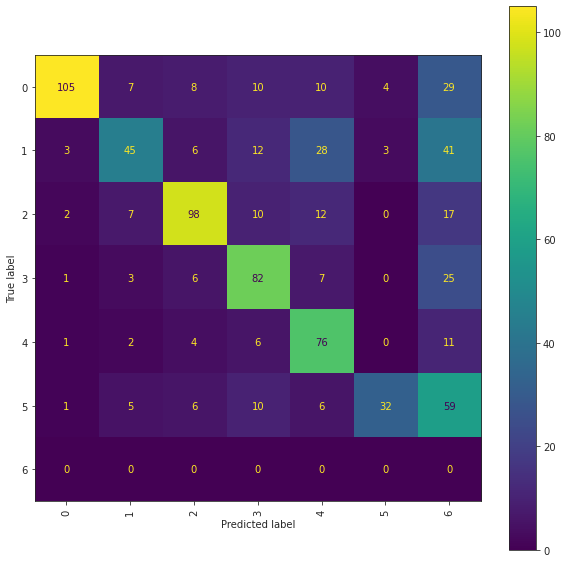

In [748]:
cm = confusion_matrix(mlb.fit_transform(true_labels).argmax(axis=1), mlb.fit_transform(predicted_labels).argmax(axis=1))

cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

cmd.plot(xticks_rotation='vertical', ax =ax)

## Attaching PoS Tagger-based features

In [749]:
postagger = pycrfsuite.Tagger()
postagger.open('en.crfsuite')

In [750]:
# Every word is represented by a set of features. CRF allows us to give any arbitrary set of features
def word2featurespos(sent, i):
    word = sent[i][0]
    postag = sent[i][2]
    features = [
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][2]
        features.extend([
            '-1:word=' + word1,
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][2]
        features.extend([
            '+1:word=' + word1,
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
        ])
    else:
        features.append('EOS')
                
    return features

def sent2featurespos(sent, postagger):
    tagged = postagger.tag(sent2features(sent))
    sentNew = [word_nelabel+(pos, ) for word_nelabel,pos in zip(sent, tagged)]
    return [word2featurespos(sentNew, i) for i in range(len(sentNew))]

def sent2labelspos(sent):
    return [label for token, label in sent]

In [751]:
for sent in train_corpus:
    print(sent)
    print("\n")
    s1 = postagger.tag(sent2features(sent))
    sentNew = [word_nelabel+(pos, ) for word_nelabel,pos in zip(sent, s1)]
    print(sentNew)
    break

[('his', 'O'), ('playlist', 'O'), ('includes', 'O'), ('sonny', 'B-PER'), ('sharrock', 'I-PER'), (',', 'O'), ('gza', 'B-PER'), (',', 'O'), ('country', 'B-GRP'), ('teasers', 'I-GRP'), ('and', 'O'), ('the', 'B-PER'), ('notorious', 'I-PER'), ('b.i.g.', 'I-PER')]


[('his', 'O', 'O'), ('playlist', 'O', 'O'), ('includes', 'O', 'O'), ('sonny', 'B-PER', 'B-PER'), ('sharrock', 'I-PER', 'I-PER'), (',', 'O', 'O'), ('gza', 'B-PER', 'B-LOC'), (',', 'O', 'O'), ('country', 'B-GRP', 'O'), ('teasers', 'I-GRP', 'O'), ('and', 'O', 'O'), ('the', 'B-PER', 'O'), ('notorious', 'I-PER', 'O'), ('b.i.g.', 'I-PER', 'O')]


In [752]:
X_train_pos = [sent2featurespos(s, postagger) for s in train_corpus]
y_train_pos = [sent2labelspos(s) for s in train_corpus]

X_test_pos = [sent2featurespos(s, postagger) for s in test_corpus]
y_test_pos = [sent2labelspos(s) for s in test_corpus]

print(X_train_pos[0][0])

['word[-3:]=his', 'word[-2:]=is', 'word.isdigit=False', 'postag=O', 'postag[:2]=O', 'BOS', '+1:word=playlist', '+1:postag=O', '+1:postag[:2]=O']


In [753]:
trainerpos = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train_pos, y_train_pos):
    trainerpos.append(xseq, yseq)

In [754]:
trainerpos.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [755]:
%%time
trainerpos.train('en-pos.crfsuite')

CPU times: user 23.6 s, sys: 2.95 ms, total: 23.6 s
Wall time: 23.6 s


In [756]:
taggerpos = pycrfsuite.Tagger()
taggerpos.open('en-pos.crfsuite')

In [757]:
%%time
y_pred_pos = [taggerpos.tag(xseq) for xseq in X_test_pos]

CPU times: user 39.2 ms, sys: 21 µs, total: 39.2 ms
Wall time: 38.5 ms


In [758]:
with codecs.open('en.out.pos.txt', 'w') as out_file:
    for every_sent,pred_label in zip(test_corpus, y_pred_pos):
        for every_word_correct_label,predicted_label in zip(every_sent, pred_label):
            out_file.write(every_word_correct_label[0] + "\t" + every_word_correct_label[1] + "\t" + predicted_label)
            out_file.write("\n")
        out_file.write("\n")

In [759]:
true_labels, predicted_labels = conllReader("en.out.pos.txt")

In [760]:
print('F1 Score is')
print( f1_score(true_labels, predicted_labels) ,'\n')

print('Classification report')
print( classification_report(true_labels, predicted_labels, scheme=IOB1) )

F1 Score is
0.6122258516098927 

Classification report
              precision    recall  f1-score   support

        CORP       0.79      0.48      0.60       193
          CW       0.41      0.17      0.24       176
         GRP       0.74      0.59      0.66       190
         LOC       0.65      0.59      0.62       234
         PER       0.81      0.81      0.81       290
        PROD       0.70      0.33      0.44       147

   micro avg       0.72      0.53      0.61      1230
   macro avg       0.68      0.49      0.56      1230
weighted avg       0.70      0.53      0.59      1230



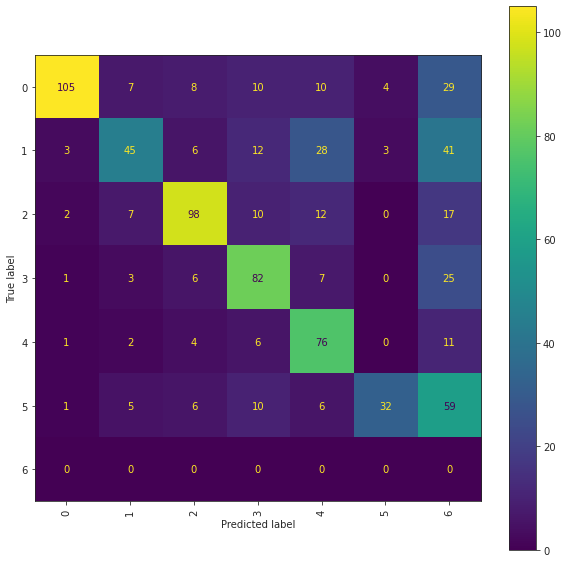

In [761]:
cm = confusion_matrix(mlb.fit_transform(true_labels).argmax(axis=1), mlb.fit_transform(predicted_labels).argmax(axis=1))

cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

cmd.plot(xticks_rotation='vertical', ax =ax)

## Adding Gazetteer features

In [762]:
from nltk.corpus.reader import plaintext

In [763]:
personGazetteer = []

mycorpus = plaintext.PlaintextCorpusReader("EN", "firstnames")
person = []
for sent in mycorpus.words():
    person.append(sent)
    
mycorpus = plaintext.PlaintextCorpusReader("EN", "lastnames")
for sent in mycorpus.words():
    person.append(sent)

person = [name.lower() for name in person]
personGazetteer = set(person)

In [764]:
# Every word is represented by a set of features. CRF allows us to give any arbitrary set of features
def word2featuresGaz(sent, i, personGaz):
    word = sent[i][0]
    features = [
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isdigit=%s' % word.isdigit(),
        'word.ispersongaz=%s' % (word in personGaz),
    ]
    if i > 0:
        word1 = sent[i-1][0]
        features.extend([
            '-1:word=' + word1
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.extend([
            '+1:word=' + word1
        ])
    else:
        features.append('EOS')
                
    return features

def word2featuresTest(sent, i):
    word = sent[i]
    features = [
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isdigit=%s' % word.isdigit()
    ]
    if i > 0:
        word1 = sent[i-1]
        features.extend([
            '-1:word=' + word1
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1]
        features.extend([
            '+1:word=' + word1
        ])
    else:
        features.append('EOS')
                
    return features

def sent2featuresGaz(sent, personGaz):
    return [word2featuresGaz(sent, i, personGaz) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

In [765]:
X_train_gaz = [sent2featuresGaz(s, personGazetteer) for s in train_corpus]
y_train_gaz = [sent2labels(s) for s in train_corpus]

X_test_gaz = [sent2featuresGaz(s, personGazetteer) for s in test_corpus]
y_test_gaz = [sent2labels(s) for s in test_corpus]

In [766]:
trainergaz = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train_gaz, y_train_gaz):
    trainergaz.append(xseq, yseq)

In [767]:
trainergaz.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 150,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [768]:
%%time
trainergaz.train('en-gaz.crfsuite')

CPU times: user 26.8 s, sys: 891 µs, total: 26.8 s
Wall time: 26.9 s


In [769]:
taggergaz = pycrfsuite.Tagger()
taggergaz.open('en-gaz.crfsuite')

In [770]:
%%time
y_pred_gaz = [taggergaz.tag(xseq) for xseq in X_test_gaz]

CPU times: user 27.7 ms, sys: 996 µs, total: 28.7 ms
Wall time: 28 ms


In [771]:
with codecs.open('en.out.gaz.txt', 'w') as out_file:
    for every_sent,pred_label in zip(test_corpus, y_pred_gaz):
        for every_word_correct_label,predicted_label in zip(every_sent, pred_label):
            out_file.write(every_word_correct_label[0] + "\t" + every_word_correct_label[1] + "\t" + predicted_label)
            out_file.write("\n")
        out_file.write("\n")

In [772]:
true_labels, predicted_labels = conllReader("en.out.gaz.txt")

In [773]:
print('F1 Score is')
print( f1_score(true_labels, predicted_labels) ,'\n')

print('Classification report')
print( classification_report(true_labels, predicted_labels, scheme=IOB1) )

F1 Score is
0.6121690664189503 

Classification report
              precision    recall  f1-score   support

        CORP       0.76      0.46      0.57       193
          CW       0.38      0.18      0.24       176
         GRP       0.72      0.59      0.65       190
         LOC       0.65      0.58      0.62       234
         PER       0.82      0.83      0.83       290
        PROD       0.74      0.34      0.47       147

   micro avg       0.71      0.54      0.61      1230
   macro avg       0.68      0.50      0.56      1230
weighted avg       0.69      0.54      0.59      1230



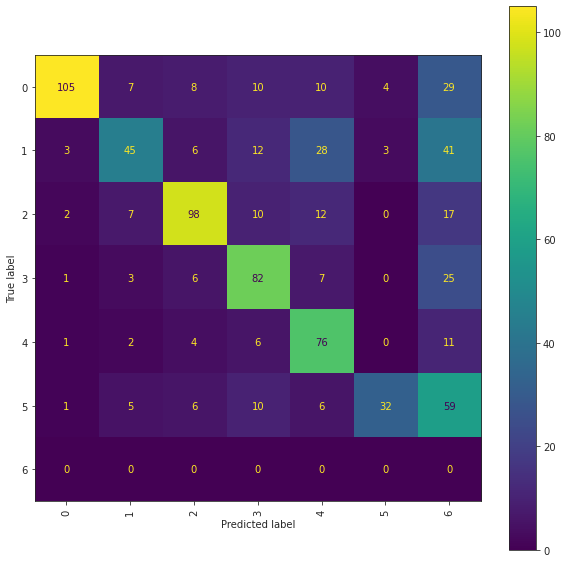

In [774]:
cm = confusion_matrix(mlb.fit_transform(true_labels).argmax(axis=1), mlb.fit_transform(predicted_labels).argmax(axis=1))

cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

cmd.plot(xticks_rotation='vertical', ax =ax)

## Adding PoS Tag feature with the Gazetteer Feature

In [775]:
# Every word is represented by a set of features. CRF allows us to give any arbitrary set of features
def word2featuresposGaz(sent, i, personGaz):
    word = sent[i][0]
    postag = sent[i][2]
    features = [
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
        'word.ispersongaz=%s' % (word in personGaz),
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][2]
        features.extend([
            '-1:word=' + word1,
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2]
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][2]
        features.extend([
            '+1:word=' + word1,
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2]
        ])
    else:
        features.append('EOS')
                
    return features

def sent2featuresposGaz(sent, personGaz, postagger):
    tagged = postagger.tag(sent2features(sent))
    sentNew = [word_nelabel+(pos, ) for word_nelabel,pos in zip(sent, tagged)]
    return [word2featuresposGaz(sentNew, i, personGaz) for i in range(len(sentNew))]

def sent2labels(sent):
    return [label for token, label in sent]

In [776]:
X_train_pos_gaz = [sent2featuresposGaz(s, personGazetteer, postagger) for s in train_corpus]
y_train_pos_gaz = [sent2labels(s) for s in train_corpus]

X_test_pos_gaz = [sent2featuresposGaz(s, personGazetteer,postagger) for s in test_corpus]
y_test_pos_gaz = [sent2labels(s) for s in test_corpus]

In [777]:
trainerposgaz = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train_pos_gaz, y_train_pos_gaz):
    trainerposgaz.append(xseq, yseq)

In [778]:
trainerposgaz.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 150,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [779]:
%%time
trainerposgaz.train('en-pos-gaz.crfsuite')

CPU times: user 34.6 s, sys: 3.64 ms, total: 34.6 s
Wall time: 34.7 s


In [780]:
taggerposgaz = pycrfsuite.Tagger()
taggerposgaz.open('en-pos-gaz.crfsuite')

In [781]:
%%time
y_pred_pos_gaz = [taggerposgaz.tag(xseq) for xseq in X_test_pos_gaz]

CPU times: user 52.2 ms, sys: 987 µs, total: 53.2 ms
Wall time: 52.7 ms


In [782]:
with codecs.open('en.out.pos.gaz.txt', 'w') as out_file:
    for every_sent,pred_label in zip(test_corpus, y_pred_pos_gaz):
        for every_word_correct_label,predicted_label in zip(every_sent, pred_label):
            out_file.write(every_word_correct_label[0] + "\t" + every_word_correct_label[1] + "\t" + predicted_label)
            out_file.write("\n")
        out_file.write("\n")

In [783]:
true_labels, predicted_labels = conllReader("en.out.pos.gaz.txt")

In [784]:
print('F1 Score is')
print( f1_score(true_labels, predicted_labels) ,'\n')

print('Classification report')
print( classification_report(true_labels, predicted_labels, scheme=IOB1) )

F1 Score is
0.6131591227251516 

Classification report
              precision    recall  f1-score   support

        CORP       0.79      0.48      0.60       193
          CW       0.41      0.17      0.24       176
         GRP       0.75      0.59      0.66       190
         LOC       0.65      0.59      0.62       234
         PER       0.81      0.81      0.81       290
        PROD       0.70      0.33      0.44       147

   micro avg       0.72      0.53      0.61      1230
   macro avg       0.68      0.50      0.56      1230
weighted avg       0.70      0.53      0.59      1230



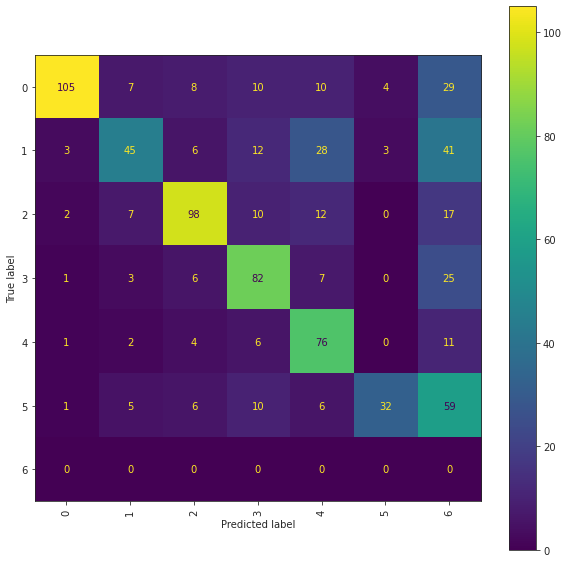

In [785]:
cm = confusion_matrix(mlb.fit_transform(true_labels).argmax(axis=1), mlb.fit_transform(predicted_labels).argmax(axis=1))

cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

cmd.plot(xticks_rotation='vertical', ax =ax)

## Plotting the relation between values of c1, c2, maximum no. of iterations, and F1 Scores 

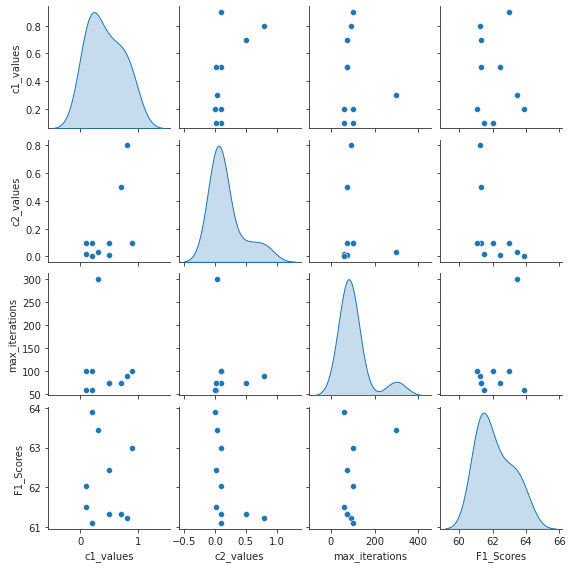

In [786]:
# Using PairPlot to visualize the bivariate relations
df = pd.DataFrame({'c1_values': [0.1, 0.1, 0.8, 0.5, 0.5, 0.7, 0.9, 0.2, 0.3, 0.2],
                   'c2_values': [0.1, 0.02, 0.8, 0.1, 0.01, 0.5, 0.1, 0.001, 0.03, 0.1],
                   'max_iterations': [100, 60, 90, 75, 75, 75, 100, 60, 300, 100],
                   'F1_Scores': [62.0212, 61.5032, 61.2364, 61.3296, 62.4245, 61.3159, 62.9876, 63.8875, 63.4521, 61.0897]})
sns.pairplot(df,
             diag_kind="kde",
             height=2
             )
plt.show()

---
---